In [1]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm
import pickle

In [2]:
BASE_PATH = '../input/coco-2017-dataset/coco2017'

In [3]:
with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_PATH}/train2017/{x}'
)
captions = captions.sample(80000)
captions = captions.reset_index(drop=True)
captions.head()

,image,caption
0,../input/coco-2017-dataset/coco2017/train2017/...,A red light at the intersection in the rain
1,../input/coco-2017-dataset/coco2017/train2017/...,Parents watching their kids play baseball at t...
2,../input/coco-2017-dataset/coco2017/train2017/...,A cat playing with a metal string sitting on a...
3,../input/coco-2017-dataset/coco2017/train2017/...,a collection of differently topped pizza slice...
4,../input/coco-2017-dataset/coco2017/train2017/...,A woman sitting on the ground holding a purple...


In [6]:

#text = "A winding road on the side of a green mountain."

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

#preprocess(text)


In [7]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()


,image,caption
0,../input/coco-2017-dataset/coco2017/train2017/...,[start] a red light at the intersection in the...
1,../input/coco-2017-dataset/coco2017/train2017/...,[start] parents watching their kids play baseb...
2,../input/coco-2017-dataset/coco2017/train2017/...,[start] a cat playing with a metal string sitt...
3,../input/coco-2017-dataset/coco2017/train2017/...,[start] a collection of differently topped piz...
4,../input/coco-2017-dataset/coco2017/train2017/...,[start] a woman sitting on the ground holding ...


[start] a couple is holding a pink sign shaped like a whale [end]



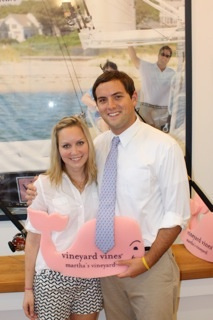

In [8]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

In [9]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 15000
BATCH_SIZE = 128
BUFFER_SIZE = 5000
EMBEDDING_DIM = 512
UNITS = 512
EPOCHS = 20

In [10]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

In [11]:
tokenizer.vocabulary_size()

12513

In [12]:
import pickle

pickle.dump(tokenizer.get_vocabulary(), open('vocab_coco.file', 'wb'))

In [13]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [14]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [15]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(64035, 64035, 15965, 15965)

In [16]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [18]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [19]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [20]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [21]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [22]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
    

    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None
        
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [23]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [24]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [25]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

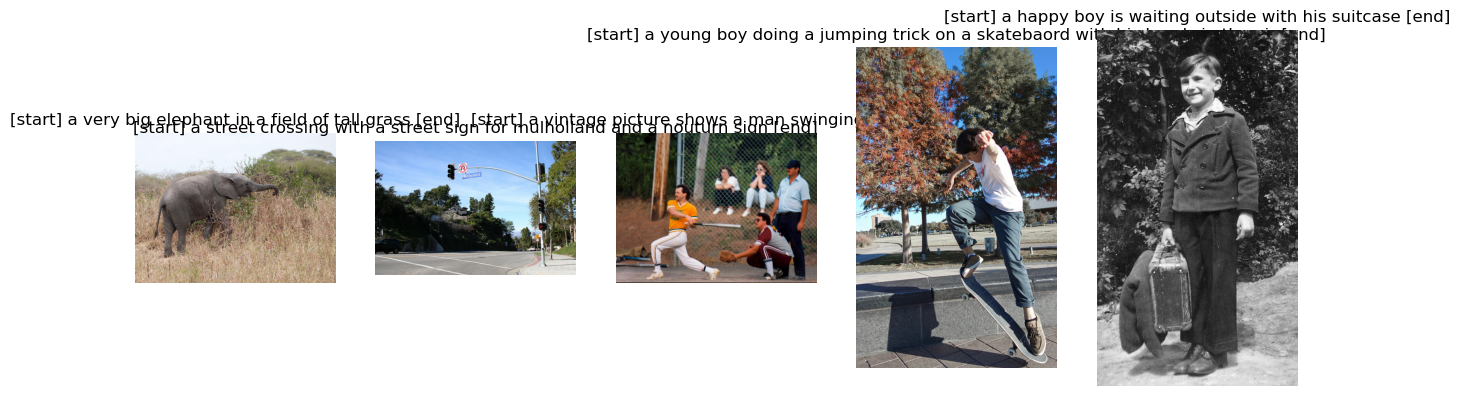

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import pandas as pd

# Assuming dataset is in a pandas DataFrame with 'image' and 'caption' columns
# Display random images with their captions
def plot_sample_images(dataframe, image_path_column, caption_column, num_samples=5):
    samples = dataframe.sample(num_samples)
    plt.figure(figsize=(15, 10))
    for i, row in enumerate(samples.itertuples()):
        img_path = getattr(row, image_path_column)  # Image file path
        caption = getattr(row, caption_column)      # Corresponding caption
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(caption)
        plt.axis('off')
    plt.show()

# Example usage
# Pass the column names as strings
plot_sample_images(captions, 'image', 'caption', num_samples=5)


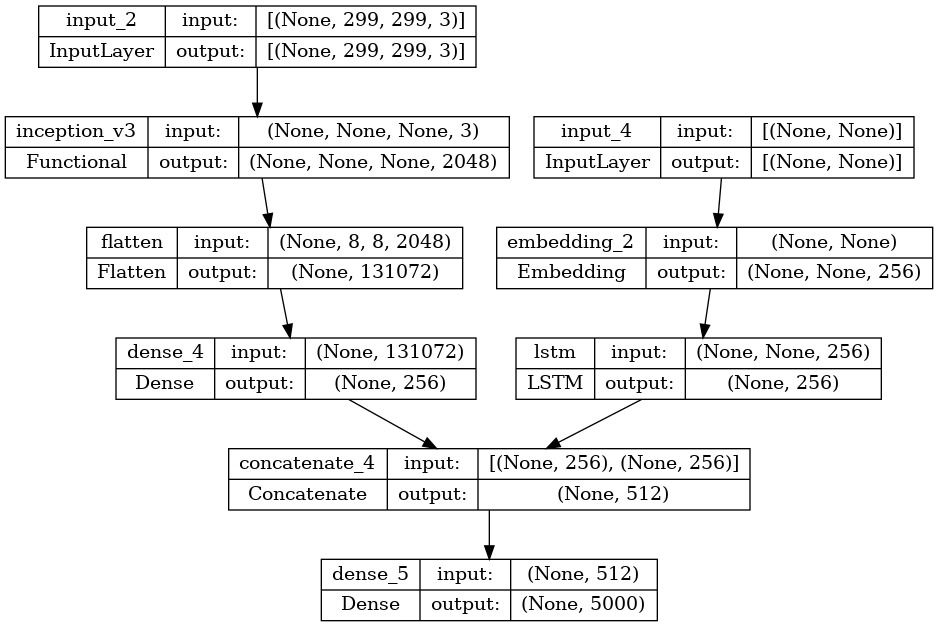

In [27]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Flatten

# Example Encoder-Decoder Model Architecture for Image Captioning

# Load pre-trained InceptionV3 for feature extraction
image_input = Input(shape=(299, 299, 3))
cnn_model = InceptionV3(include_top=False, weights='imagenet')
cnn_output = cnn_model(image_input)

# Flatten the CNN output to feed it into the RNN
cnn_flatten = Flatten()(cnn_output)  # Flatten the 4D CNN output to 2D

# Add a Dense layer to process the flattened output
cnn_dense = Dense(256, activation='relu')(cnn_flatten)

# RNN for text generation (LSTM with embedding layer)
caption_input = Input(shape=(None,))
embedding = Embedding(input_dim=5000, output_dim=256)(caption_input)
lstm_output = LSTM(256)(embedding)

# Combine the CNN and LSTM outputs using Concatenate
merged = Concatenate()([cnn_dense, lstm_output])

# Apply the final Dense layer for prediction
decoder_output = Dense(5000, activation='softmax')(merged)

# Model definition
model = Model(inputs=[image_input, caption_input], outputs=decoder_output)

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


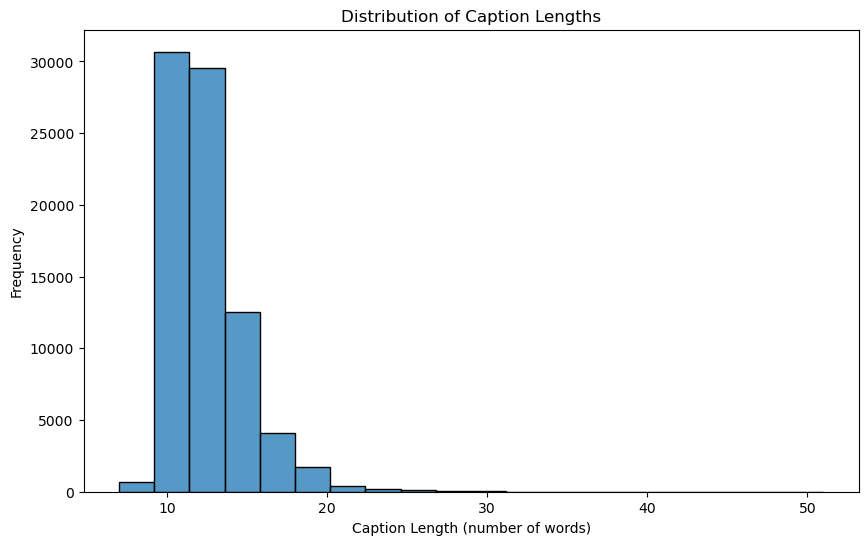

In [28]:
import seaborn as sns

# Assuming captions are stored in a column of the DataFrame
# Calculate the length of each caption
captions['caption_length'] = captions['caption'].apply(lambda x: len(x.split()))

# Plot distribution of caption lengths
plt.figure(figsize=(10, 6))
sns.histplot(captions['caption_length'], kde=False, bins=20)
plt.title('Distribution of Caption Lengths')
plt.xlabel('Caption Length (number of words)')
plt.ylabel('Frequency')
plt.show()


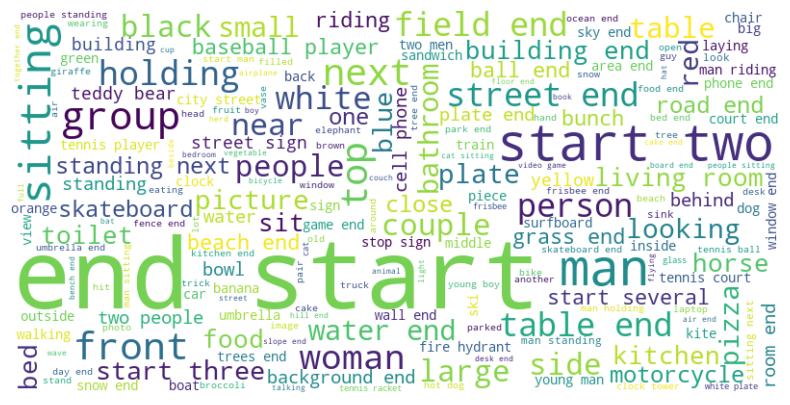

In [29]:
from wordcloud import WordCloud

# Combine all captions into a single string
all_captions = ' '.join(captions['caption'].values)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_captions)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


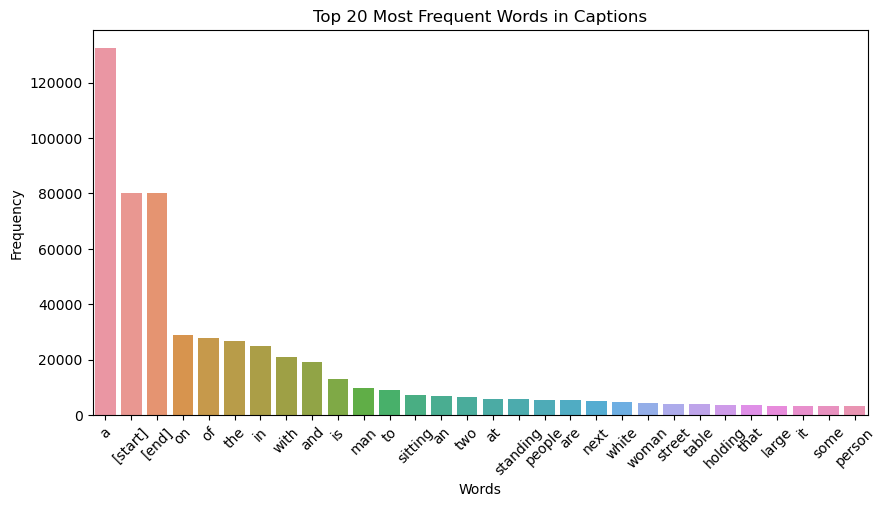

In [30]:
from collections import Counter

# Tokenize captions and count word frequencies
word_list = ' '.join(captions['caption']).split()
word_freq = Counter(word_list)

# Get the 20 most common words
common_words = word_freq.most_common(30)

# Separate words and their frequencies for plotting
words, frequencies = zip(*common_words)

# Plot the frequencies of common words
plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(frequencies))
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words in Captions')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


In [ ]:
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/20
 23/501 [>.............................] - ETA: 16:50 - loss: 6.2979 - acc: 0.1333

In [ ]:
def plot_training_history(history):
    # History object contains 'loss' and optionally 'accuracy' or 'val_accuracy'
    plt.figure(figsize=(12, 5))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.show()

# Assuming you have a 'history' object after training your model
plot_training_history(history)


In [ ]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)
    
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

In [ ]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

In [ ]:
#img_url = "https://images.squarespace-cdn.com/content/v1/5e0e65adcd39ed279a0402fd/1627422658456-7QKPXTNQ34W2OMBTESCJ/1.jpg?format=2500w"
#img_url = "https://tensorflow.org/images/surf.jpg" #a man riding a surf board on a wave


#img_url = "https://miro.medium.com/v2/resize:fit:524/format:webp/1*tVETPw5HjXoNM9Ne5DSZWA.jpeg"
#img_url = "https://www.thesprucepets.com/thmb/3ABKoAPm0Hu4PcWsDH1giawq7ck=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/chinese-dog-breeds-4797219-hero-2a1e9c5ed2c54d00aef75b05c5db399c.jpg"
#img_url = "https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg?w=400&h=300&c=crop"
img_url = "https://cdn.theatlantic.com/thumbor/viW9N1IQLbCrJ0HMtPRvXPXShkU=/0x131:2555x1568/976x549/media/img/mt/2017/06/shutterstock_319985324/original.jpg"
#img_url = "https://i.abcnewsfe.com/a/54508fa4-688e-4072-bbf0-67930d1d0336/baseball-1-ap-gmh-230901_1693579673197_hpMain.jpg"
#img_url = "https://www.vipervolleyball.org/wp-content/uploads/2022/10/IMG_20191214_132039-768x432.jpg"






im = Image.open(requests.get(img_url, stream=True).raw)
im = im.convert('RGB')
im.save('tmp.jpg')

pred_caption = generate_caption('tmp.jpg', add_noise=False)
print('Predicted Caption:', pred_caption)
print()
im

In [ ]:
caption_model.save('model.h5')

In [ ]:
import pickle

# Extract and save the tokenizer's vocabulary
vocab = tokenizer.get_vocabulary()
with open('vocab_coco.pkl', 'wb') as f:
    pickle.dump(vocab, f)


In [ ]:
# Save the model in TensorFlow's SavedModel format
caption_model.save('saved_model', save_format='tf')


In [ ]:
import tensorflow as tf
import pickle

# Load the vocabulary
with open('vocab_coco.pkl', 'rb') as f:
    vocab = pickle.load(f)


In [ ]:
import json
import tensorflow as tf

# Load the tokenizer configuration
with open('tokenizer_config.json', 'r') as f:
    config = json.load(f)

# Recreate the TextVectorization layer with the loaded configuration
tokenizer = tf.keras.layers.TextVectorization.from_config(config)
tokenizer.set_vocabulary(vocab)


 ****END OF CODE****